In [528]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, classification_report, confusion_matrix

In [457]:
data = pd.read_csv('bank-additional-full.csv', sep = ';')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [458]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [459]:
data.shape

(41188, 21)

In [460]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Age: Основная масса клиентов — люди среднего возраста (от 30 до 50 лет). Наличие клиентов старше 80 лет (max=98) является статистическим выбросом и требует проверки на предмет ошибки в данных. Маркетинговые кампании банка ориентированы на экономически активное население.
Duration: Распределение сильно скошено вправо. 75% звонков длятся менее 5.5 минут (319 сек). Наличие звонков длительностью более часа (максимальное значение) — аномалия. Главный инсайт: этот признак — мощный предиктор успеха (чем дольше разговор, тем вероятнее успех), но его нельзя использовать для прогноза будущих кампаний, так как длительность звонка неизвестна до его совершения. Это "data leakage" признак.
Campaign: В рамках одной кампании большинству клиентов звонили 1-3 раза. Однако наличие значений в 10, 20 и даже 50 разов контактов (max=56) указывает на крайне агрессивную и навязчивую тактику по отношению к некоторым клиентам, которая, скорее всего, даёт обратный эффект.
pdays: Это не числовой признак, а категориальный флаг. Значение 999 повсеместно используется для кодировки клиентов, с которыми не контактировали в предыдущих кампаниях. Тот факт, что у 75% и более клиентов стоит это значение, говорит о том, что это в основном "холодная" база, а не база постоянных клиентов. Это меняет подход к обработке признака: его нужно преобразовать в бинарный признак.
previous:  У 75% клиентов не было контактов в предыдущих кампаниях (previous=0). Это подтверждает вывод по pdays о "холодной" базе. У небольшой доли клиентов было много контактов, что может быть связано либо с их лояльностью, либо с настойчивостью менеджеров.
Макроэкономические показатели: 
emp.var.rate (Изменение уровня занятости): 
Отрицательное значение (например, -3.0): Значит, безработица растёт. Людей увольняют, новые рабочие места не создаются. Люди боятся тратить деньги, экономят и не думают о вкладах.
Положительное значение (например, 1.5): Экономика на подъёме! Безработица падает, у людей есть стабильная работа и деньги. Они больше доверяют банкам и готовы инвестировать.
euribor3m (Процентная ставка Euribor на 3 месяца): Это цена денег для банков.
Низкое значение (например, 0.5%): Банкам очень дёшево брать деньги в долг друг у друга. Значит, они могут предлагать вам высокие проценты по вкладам, чтобы привлечь ваши деньги. Вклады становятся выгодными.
Высокое значение (например, 5%): Кредиты для самих банков становятся дорогими. Им нет смысла предлагать вам высокие проценты, так как это нерентабельно. Вклады становятся неинтересными
cons.conf.idx (Индекс потребительской уверенности): Это настроение людей.
Низкое значение (например, -50): Люди пессимистичны. Боятся кризиса, безработицы. 
Высокое значение: Люди оптимистичны, верят в завтрашний день, готовы тратить и инвестировать.

Поведение человека сильно зависит от общей экономической ситуации. Когда в стране кризис (emp.var.rate отрицательный, cons.conf.idx низкий), почти все перестают доверять банкам и откладывают крупные финансовые решения. Когда всё хорошо — наоборот. Эти признаки не говорят о конкретном человеке (его работе, возрасте, семье). Они говорят о дне, в который ему позвонили. Если в этот день была плохая экономическая обстановка, вероятность успеха звонка всем клиентам падала. И наоборот. Все эти признаки сильно связаны между собой. Когда растёт безработица (emp.var.rate падает) -> настроение людей ухудшается (cons.conf.idx падает) -> центробанк снижает ставки (euribor3m падает), чтобы поддержать экономику. Из-за того что признаки повторяют друг друга, нет смысла тащить их все в модель. Нужно выбрать самые показательные. 

In [461]:
data.dtypes.value_counts()

object     11
int64       5
float64     5
Name: count, dtype: int64

In [462]:
data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [463]:
categorical_columns = data.select_dtypes(include=['object']).columns

for column in categorical_columns:
    print(f"\n {column} ({data[column].nunique()} уникальных значений):")
    print(data[column].value_counts().head(10)) 


 job (12 уникальных значений):
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
Name: count, dtype: int64

 marital (4 уникальных значений):
marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64

 education (8 уникальных значений):
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

 default (3 уникальных значений):
default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64

 housing (3 уникальных значений):
housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64

 loan (3 уникальных з

In [464]:
data_analysis = data.copy()

In [465]:
data_analysis['y'] = data_analysis['y'].map({'yes': 1, 'no': 0})

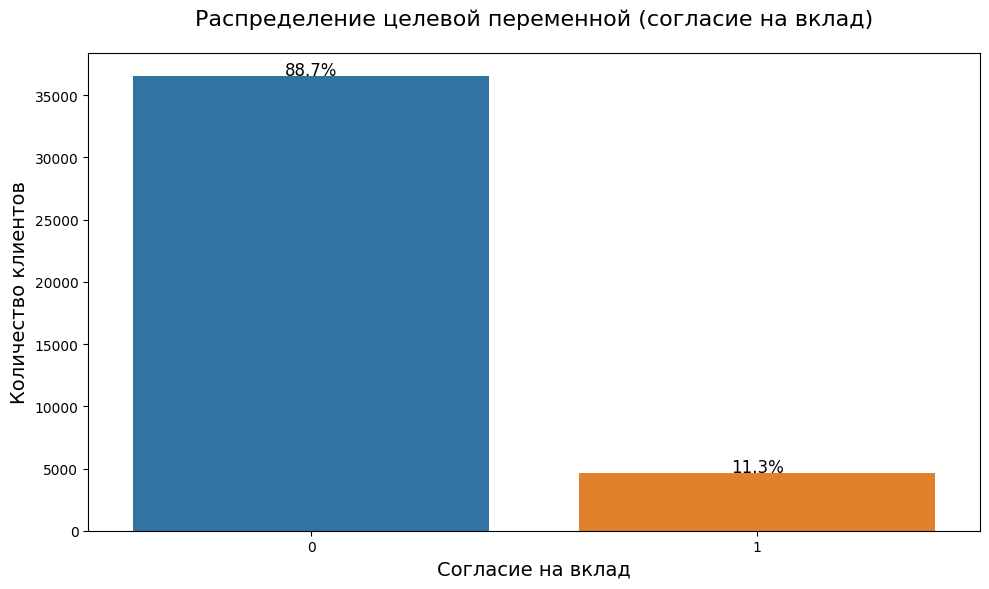

In [466]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='y', data=data_analysis, hue='y', legend=False)
plt.title('Распределение целевой переменной (согласие на вклад)', fontsize=16, pad=20)
plt.xlabel('Согласие на вклад', fontsize=14)
plt.ylabel('Количество клиентов', fontsize=14)

total = len(data_analysis)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 100
    ax.annotate(percentage, (x, y), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

Заметен сильный дисбаланс классов

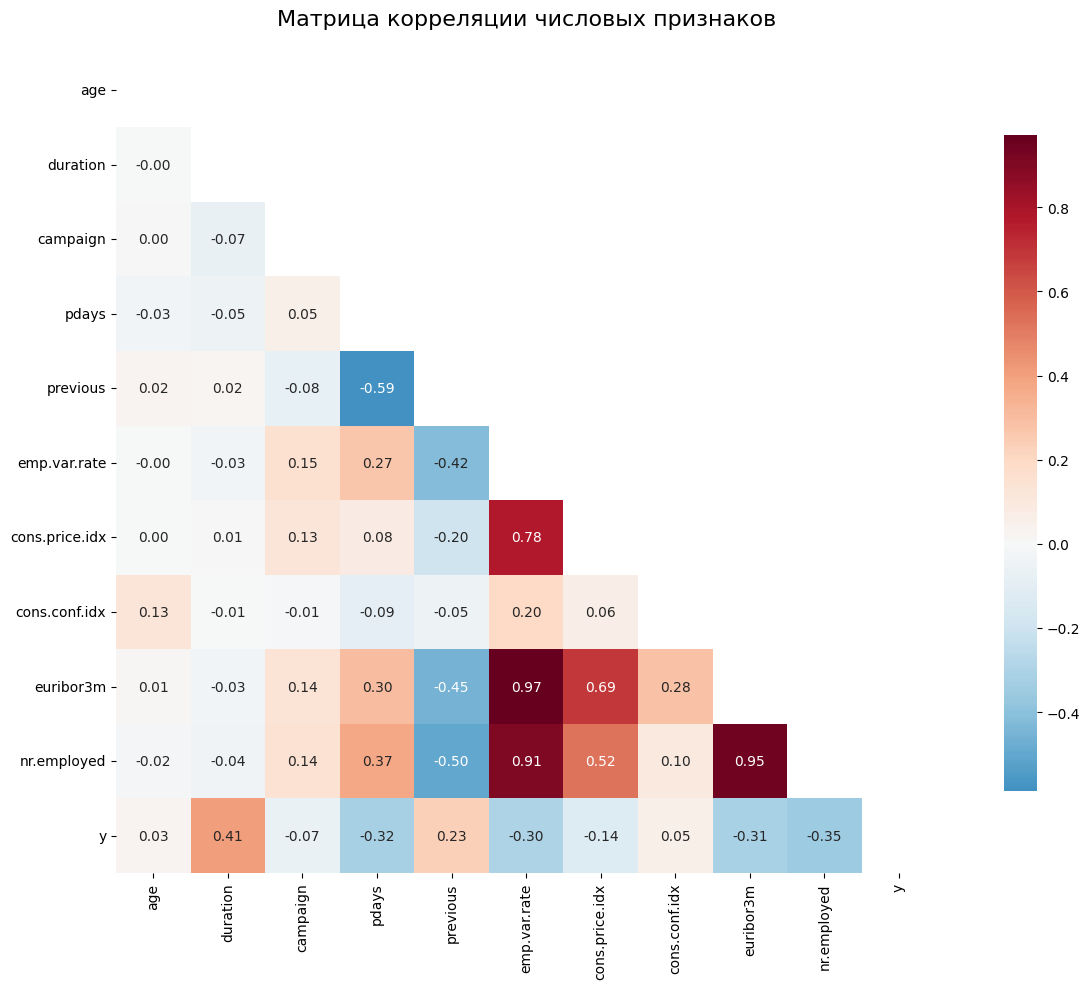

In [467]:
numeric_data = data_analysis.select_dtypes(include=[np.number])

plt.figure(figsize=(14, 10))
corr_matrix = numeric_data.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8})

plt.title('Матрица корреляции числовых признаков', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

Сильные корреляции между макроэкономическими показателями (euribor3m, emp.var.rate, nr.employed). Это классическая мультиколлинеарность. Три признака практически дублируют друг друга. Использовать все три в модели нельзя — это ухудшит ее стабильность и интерпретируемость. 

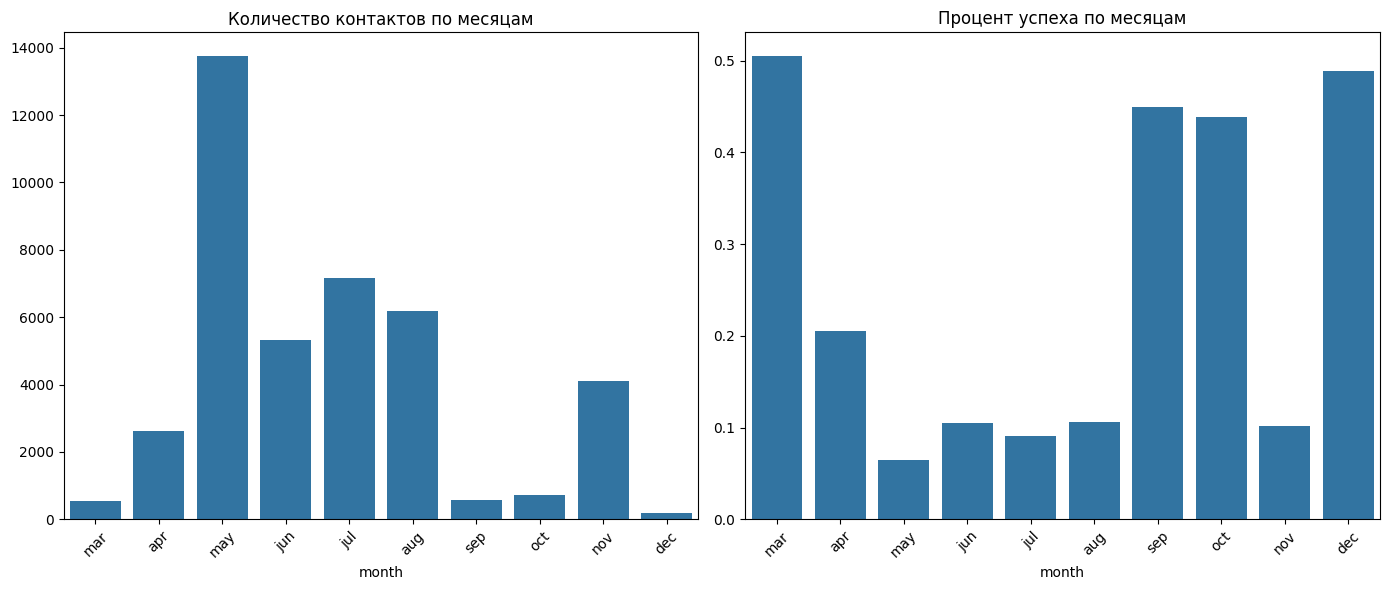

In [468]:
month_order = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
month_counts = data_analysis['month'].value_counts().reindex(month_order)
sns.barplot(x=month_counts.index, y=month_counts.values)
plt.title('Количество контактов по месяцам')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
month_success = data_analysis.groupby('month')['y'].mean().reindex(month_order)
sns.barplot(x=month_success.index, y=month_success.values)
plt.title('Процент успеха по месяцам')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Количество контактов по месяцам: Маркетинговая активность неравномерна в течение года с явным смещением в сторону летних месяцев.
Процент успеха по месяцам: Эффективность кампании обратно пропорциональна активности — чем больше контактов, тем ниже процент успеха
Банк тратит больше ресурсов в наименее эффективные месяцы и недоиспользует наиболее перспективные периоды.

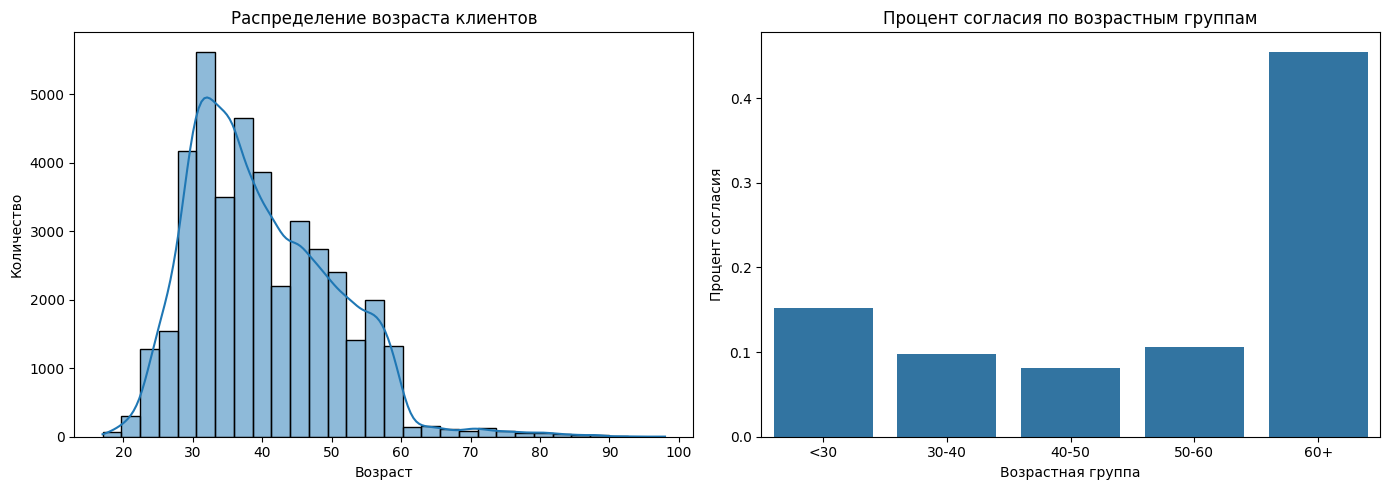

In [469]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(data_analysis['age'], bins=30, kde=True)
plt.title('Распределение возраста клиентов')
plt.xlabel('Возраст')
plt.ylabel('Количество')

plt.subplot(1, 2, 2)
data_analysis['age_group'] = pd.cut(data_analysis['age'], 
                                 bins=[0, 30, 40, 50, 60, 100],
                                 labels=['<30', '30-40', '40-50', '50-60', '60+'])
age_success = data_analysis.groupby('age_group', observed=False)['y'].mean()
sns.barplot(x=age_success.index, y=age_success.values)
plt.title('Процент согласия по возрастным группам')
plt.xlabel('Возрастная группа')
plt.ylabel('Процент согласия')

plt.tight_layout()
plt.show()

Распределение возраста клиентов: Банк работает преимущественно с клиентами среднего возраста (30-50 лет), что соответствует экономически активному населению.
Процент согласия по возрастным группам: Существует четкая возрастная зависимость — чем старше клиент, тем выше вероятность согласия на вклад.

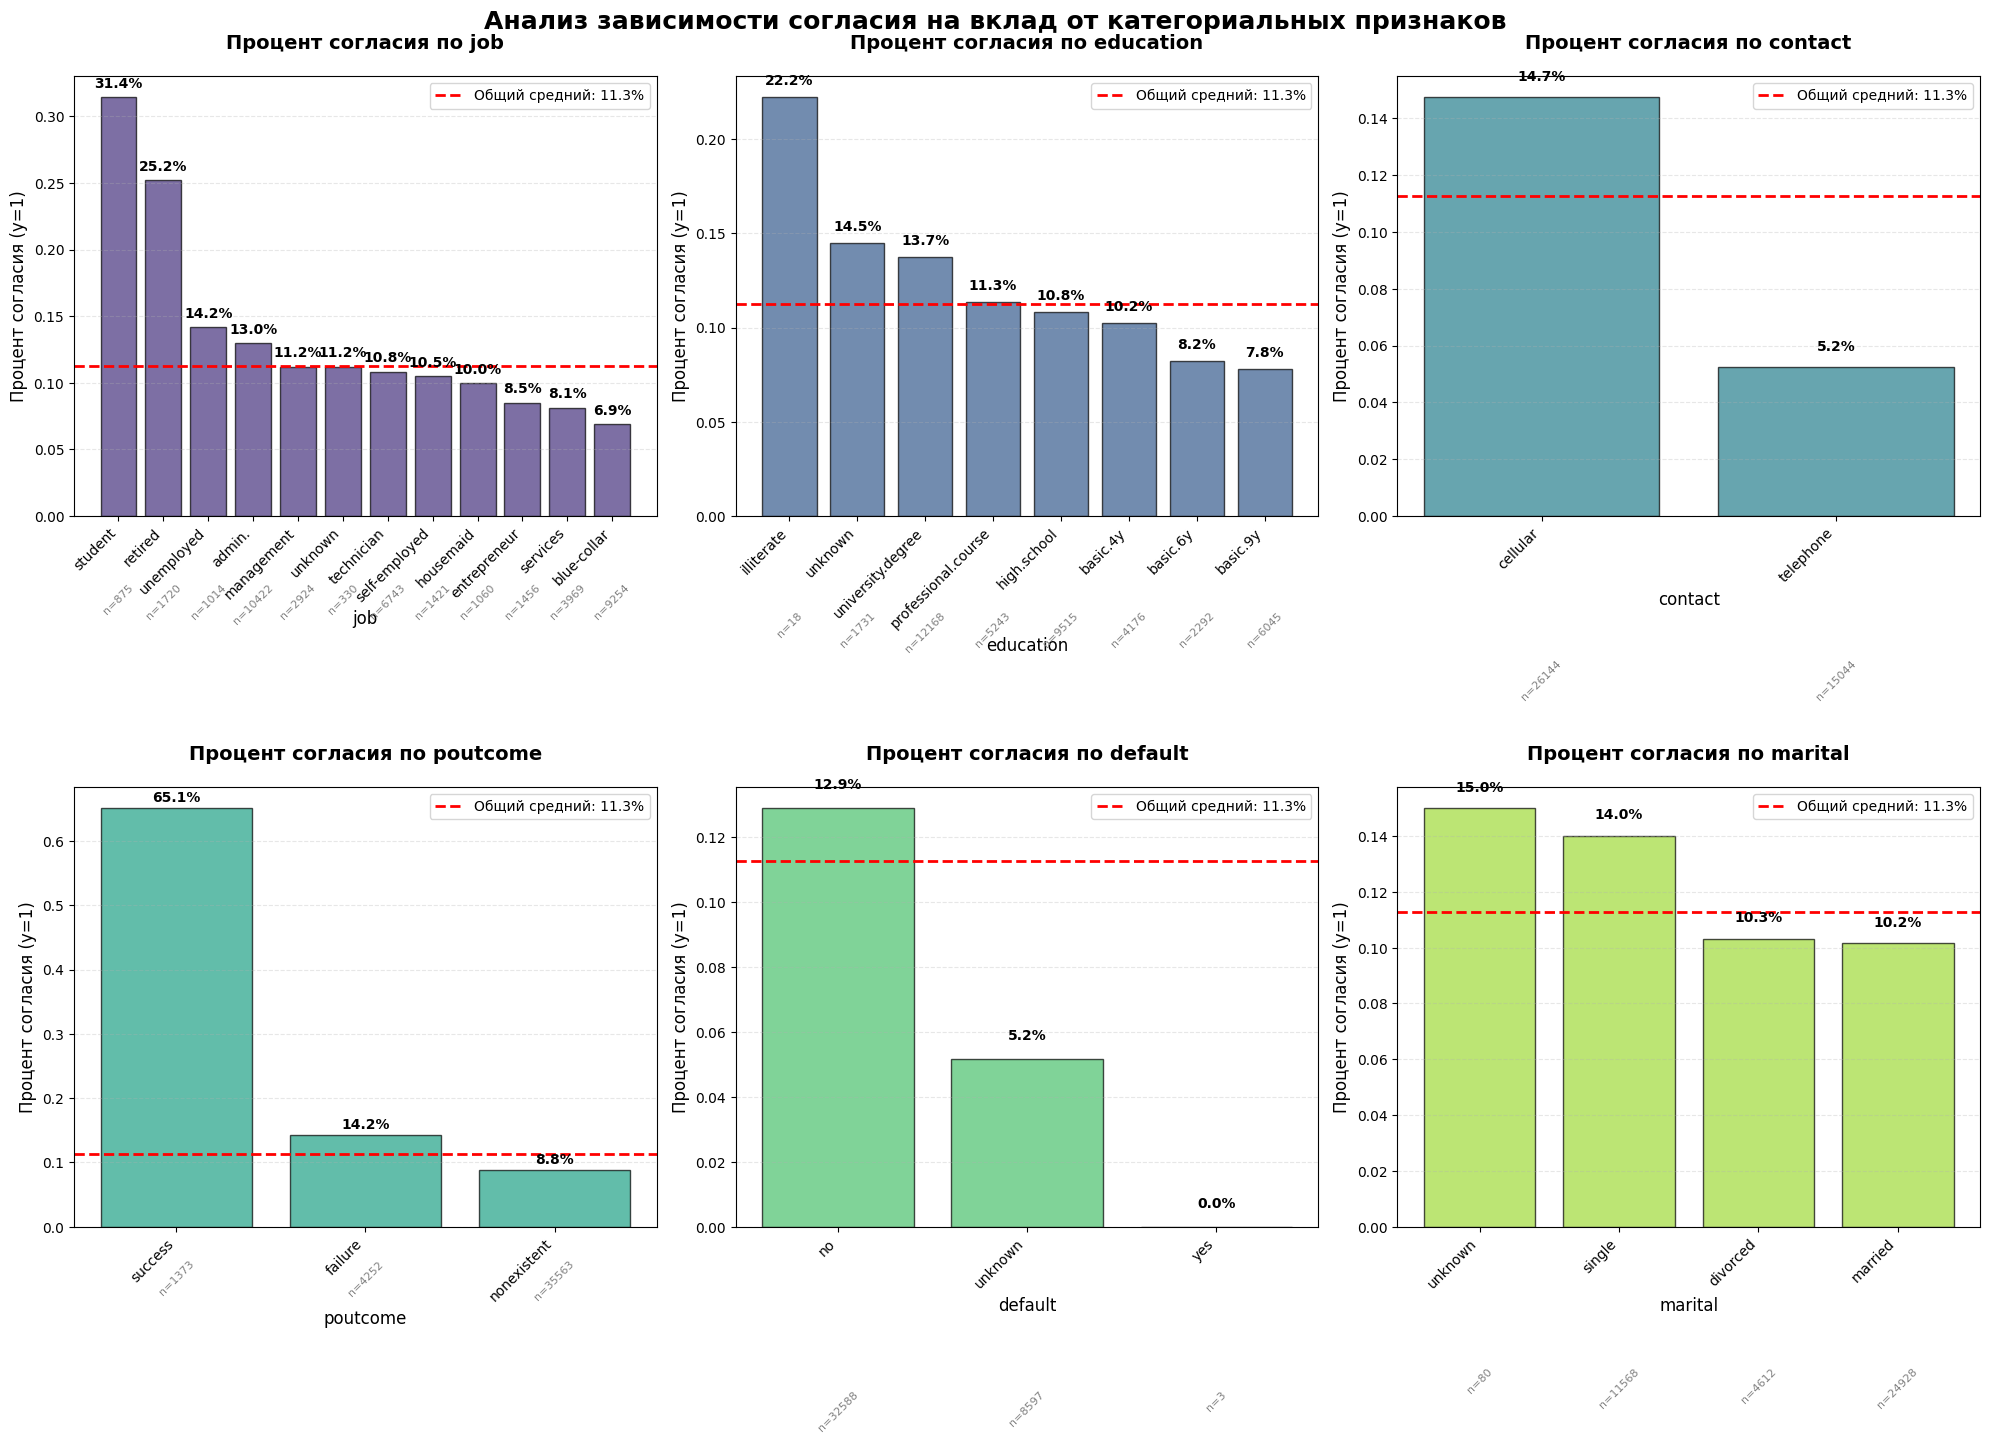

In [470]:
cat_features = ['job', 'education', 'contact', 'poutcome', 'default', 'marital']

fig, axes = plt.subplots(2, 3, figsize=(20, 15))
axes = axes.ravel()

colors = sns.color_palette("viridis", len(cat_features))

for i, feature in enumerate(cat_features):
    grouped_data = data_analysis.groupby(feature)['y'].agg(['mean', 'count']).reset_index()
    grouped_data = grouped_data.sort_values('mean', ascending=False)
    
    if feature == 'month':
        month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
        grouped_data[feature] = pd.Categorical(grouped_data[feature], categories=month_order, ordered=True)
        grouped_data = grouped_data.sort_values(feature)
    
    bars = axes[i].bar(range(len(grouped_data)), grouped_data['mean'], 
                      color=colors[i], alpha=0.7, edgecolor='black')
    
    for j, (mean_val, count_val) in enumerate(zip(grouped_data['mean'], grouped_data['count'])):
        axes[i].text(j, mean_val + 0.005, f'{mean_val:.1%}', 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
        axes[i].text(j, -0.05, f'n={count_val}', 
                    ha='center', va='top', fontsize=8, rotation=45, color='gray')
    
    axes[i].set_title(f'Процент согласия по {feature}', fontsize=14, pad=20, fontweight='bold')
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Процент согласия (y=1)', fontsize=12)
    axes[i].set_xticks(range(len(grouped_data)))
    axes[i].set_xticklabels(grouped_data[feature], rotation=45, ha='right')
    axes[i].grid(axis='y', alpha=0.3, linestyle='--')
    
    overall_mean = data_analysis['y'].mean()
    axes[i].axhline(y=overall_mean, color='red', linestyle='--', linewidth=2, 
                   label=f'Общий средний: {overall_mean:.1%}')
    axes[i].legend()

for j in range(len(cat_features), 6):
    fig.delaxes(axes[j])

plt.suptitle('Анализ зависимости согласия на вклад от категориальных признаков', 
             fontsize=18, y=0.98, fontweight='bold')
plt.tight_layout()
plt.show()

Данные показывают четкие и сильные зависимости между категориальными признаками и вероятностью согласия на вклад. Профессия является сильным предиктором успеха кампании. Тип контакта критически важен для успеха кампании. Poutcome - наиболее значимый признак - прошлый опыт клиента с банком сильно влияет на текущий результат. 

In [471]:
y

np.float64(4740.0)

In [472]:
data.columns.tolist()

['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'y']

In [473]:
text_columns = data.select_dtypes(include=['object']).columns
print(f"\nТекстовые колонки: {list(text_columns)}")


Текстовые колонки: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


In [474]:
for col in text_columns:
        unique_vals = data[col].unique()
        print(f"Колонка '{col}': {unique_vals}")
        if set(unique_vals) == {'yes', 'no'} or set(unique_vals) == {'Yes', 'No'}:
            print(f"НАЙДЕНА КОЛОНКА С МЕТКАМИ: {col}")
            y_correct = data[col]
            break

Колонка 'job': ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
Колонка 'marital': ['married' 'single' 'divorced' 'unknown']
Колонка 'education': ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
Колонка 'default': ['no' 'unknown' 'yes']
Колонка 'housing': ['no' 'yes' 'unknown']
Колонка 'loan': ['no' 'yes' 'unknown']
Колонка 'contact': ['telephone' 'cellular']
Колонка 'month': ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
Колонка 'day_of_week': ['mon' 'tue' 'wed' 'thu' 'fri']
Колонка 'poutcome': ['nonexistent' 'failure' 'success']
Колонка 'y': ['no' 'yes']
НАЙДЕНА КОЛОНКА С МЕТКАМИ: y


In [475]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_correct)

In [476]:
y_encoded.shape

(41188,)

In [477]:
data['y_encoded'] = y_encoded

print(data[['y', 'y_encoded']].head(10))

    y  y_encoded
0  no          0
1  no          0
2  no          0
3  no          0
4  no          0
5  no          0
6  no          0
7  no          0
8  no          0
9  no          0


In [478]:
data.drop('y', axis=1, inplace=True)

In [479]:
data['pdays_contact'] = data['pdays'].apply(lambda x: 1 if x < 999 else 0)

# Удаляем исходный признак pdays
data.drop('pdays', axis=1, inplace=True)

In [480]:
data.drop('duration', axis=1, inplace=True)

In [481]:
macro_features_to_keep = ['emp.var.rate', 'cons.conf.idx']
macro_features_to_drop = ['cons.price.idx', 'euribor3m', 'nr.employed']

data.drop(macro_features_to_drop, axis=1, inplace=True)

In [482]:
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,emp.var.rate,cons.conf.idx,y_encoded,pdays_contact
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,0,nonexistent,1.1,-36.4,0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,0,nonexistent,1.1,-36.4,0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,0,nonexistent,1.1,-36.4,0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,0,nonexistent,1.1,-36.4,0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,0,nonexistent,1.1,-36.4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,0,nonexistent,-1.1,-50.8,1,0
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,0,nonexistent,-1.1,-50.8,0,0
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,0,nonexistent,-1.1,-50.8,0,0
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,0,nonexistent,-1.1,-50.8,1,0


In [483]:
data.dtypes

age                int64
job               object
marital           object
education         object
default           object
housing           object
loan              object
contact           object
month             object
day_of_week       object
campaign           int64
previous           int64
poutcome          object
emp.var.rate     float64
cons.conf.idx    float64
y_encoded          int64
pdays_contact      int64
dtype: object

Разделяем данные на тестовую и обучающую выборки

In [484]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('y_encoded', axis=1), data['y_encoded'], random_state = 42)

print(X_train.shape, X_test.shape)

(30891, 16) (10297, 16)


In [485]:
numeric_features = ['age', 'campaign', 'previous']

macro_features = ['emp.var.rate', 'cons.conf.idx']

binary_features = ['default', 'housing', 'loan']

ordinal_features = ['education']
education_order = ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 
                  'high.school', 'professional.course', 'university.degree', 'unknown']

categorical_features = ['job', 'marital', 'contact', 'month', 'day_of_week', 'poutcome']

Числовые: Требуют масштабирования
Бинарные: Простое кодирование 0/1
Порядковые: Имеют естественный порядок (образование)
Категориальные: Без естественного порядка, требуют One-Hot Encoding

In [486]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Заполняем пропуски медианным значением
    ('scaler', StandardScaler())  # Стандартизируем: вычитаем mean, делим на std (mean=0, std=1)
])

In [487]:
macro_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Заполняем пропуски
    ('scaler', StandardScaler())  # Стандартизируем
])

In [488]:
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Заполняем пропуски самым частым значением
    ('encoder', OneHotEncoder(drop='if_binary', sparse_output=False))  # Кодируем в 0/1, drop убирает избыточность
])

In [489]:
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),  # Заполняем пропуски значением 'unknown'
    ('encoder', OrdinalEncoder(categories=[education_order], handle_unknown='use_encoded_value', unknown_value=-1))
    # Преобразуем в числа с сохранением порядка, неизвестные значения -> -1
])

In [490]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),  # Заполняем пропуски
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-Hot кодирование
    # handle_unknown='ignore' - если встретится новая категория в test, игнорируем её
])

In [491]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('macro', macro_transformer, macro_features),
        ('binary', binary_transformer, binary_features),
        ('ordinal', ordinal_transformer, ordinal_features),
        ('categorical', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # Все остальные столбцы, не указанные выше, будут удалены
)

preprocessor

,transformers,"[('numeric', ...), ('macro', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [515]:
classifier_pipline = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", LogisticRegression(
               max_iter=1000, 
               class_weight="balanced", 
               random_state=42, 
               solver='liblinear'))])

classifier_pipline

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('macro', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [493]:
all_features = data.drop('y_encoded', axis=1).columns.tolist()
target = 'y_encoded'

In [494]:
print("Тип all_features:", type(all_features))
print("Тип target:", type(target))
print("all_features:", all_features)
print("target:", target)

Тип all_features: <class 'list'>
Тип target: <class 'str'>
all_features: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'previous', 'poutcome', 'emp.var.rate', 'cons.conf.idx', 'pdays_contact']
target: y_encoded


In [495]:
data_train, data_test = train_test_split(data[all_features + [target]], test_size=0.2, stratify=data[target], random_state = 42)

In [516]:
classifier_pipline.fit(data_train[all_features], data_train[target])

preds = classifier_pipline.predict(data_test[all_features])
preds_proba = classifier_pipline.predict_proba(data_test[all_features])[:, 1]  # вероятности для класса 1

# Расчет всех метрик
accuracy = accuracy_score(data_test[target], preds)
precision = precision_score(data_test[target], preds)
recall = recall_score(data_test[target], preds)
f1 = f1_score(data_test[target], preds)
roc_auc = roc_auc_score(data_test[target], preds_proba)

cm = confusion_matrix(data_test[target], preds)
tn, fp, fn, tp = cm.ravel()

# Дополнительные метрики
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
balanced_accuracy = (recall + specificity) / 2
false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

metrics_table = pd.DataFrame({
    'Метрика': [
        'Accuracy (Точность)',
        'Precision (Точность+)', 
        'Recall (Полнота)',
        'F1-Score (F-мера)',
        'ROC-AUC',
        'Specificity (Специфичность)',
        'Balanced Accuracy',
        'False Positive Rate'
    ],
    'Значение': [
        f"{accuracy:.4f}",
        f"{precision:.4f}", 
        f"{recall:.4f}",
        f"{f1:.4f}",
        f"{roc_auc:.4f}",
        f"{specificity:.4f}",
        f"{balanced_accuracy:.4f}",
        f"{false_positive_rate:.4f}"
    ],
    'Интерпретация': [
        'Доля правильных предсказаний',
        'Качество предсказания положительного класса',
        'Способность находить положительные классы',
        'Баланс между точностью и полнотой',
        'Качество разделения классов',
        'Способность находить отрицательные классы',
        'Среднее чувствительности и специфичности',
        'Доля ложных срабатываний'
    ]
})

print("МЕТРИКИ КАЧЕСТВА МОДЕЛИ LOGISTIC REGRESSION")
print(metrics_table.to_string(index=False))

МЕТРИКИ КАЧЕСТВА МОДЕЛИ LOGISTIC REGRESSION
                    Метрика Значение                               Интерпретация
        Accuracy (Точность)   0.8182                Доля правильных предсказаний
      Precision (Точность+)   0.3415 Качество предсказания положительного класса
           Recall (Полнота)   0.6616   Способность находить положительные классы
          F1-Score (F-мера)   0.4505           Баланс между точностью и полнотой
                    ROC-AUC   0.7977                 Качество разделения классов
Specificity (Специфичность)   0.8380   Способность находить отрицательные классы
          Balanced Accuracy   0.7498    Среднее чувствительности и специфичности
        False Positive Rate   0.1620                    Доля ложных срабатываний


In [513]:
classifier_pipline = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", CatBoostClassifier(
               iterations=200, 
               depth=6, 
               learning_rate=0.03, 
               loss_function="Logloss", 
               verbose=0, 
               random_state=42))])
classifier_pipline

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('macro', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [514]:
classifier_pipline.fit(data_train[all_features], data_train[target])

preds = classifier_pipline.predict(data_test[all_features]).astype(bool)
preds_proba = classifier_pipline.predict_proba(data_test[all_features])[:, 1]  # вероятности для класса 1

# Расчет всех метрик
accuracy = accuracy_score(data_test[target], preds)
precision = precision_score(data_test[target], preds)
recall = recall_score(data_test[target], preds)
f1 = f1_score(data_test[target], preds)
roc_auc = roc_auc_score(data_test[target], preds_proba)

cm = confusion_matrix(data_test[target], preds)
tn, fp, fn, tp = cm.ravel()

# Дополнительные метрики
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
balanced_accuracy = (recall + specificity) / 2
false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

metrics_table = pd.DataFrame({
    'Метрика': [
        'Accuracy (Точность)',
        'Precision (Точность+)', 
        'Recall (Полнота)',
        'F1-Score (F-мера)',
        'ROC-AUC',
        'Specificity (Специфичность)',
        'Balanced Accuracy',
        'False Positive Rate'
    ],
    'Значение': [
        f"{accuracy:.4f}",
        f"{precision:.4f}", 
        f"{recall:.4f}",
        f"{f1:.4f}",
        f"{roc_auc:.4f}",
        f"{specificity:.4f}",
        f"{balanced_accuracy:.4f}",
        f"{false_positive_rate:.4f}"
    ],
    'Интерпретация': [
        'Доля правильных предсказаний',
        'Качество предсказания положительного класса',
        'Способность находить положительные классы',
        'Баланс между точностью и полнотой',
        'Качество разделения классов',
        'Способность находить отрицательные классы',
        'Среднее чувствительности и специфичности',
        'Доля ложных срабатываний'
    ]
})

print("МЕТРИКИ КАЧЕСТВА МОДЕЛИ CATBOOST")
print(metrics_table.to_string(index=False))


МЕТРИКИ КАЧЕСТВА МОДЕЛИ CATBOOST
                    Метрика Значение                               Интерпретация
        Accuracy (Точность)   0.9006                Доля правильных предсказаний
      Precision (Точность+)   0.7261 Качество предсказания положительного класса
           Recall (Полнота)   0.1886   Способность находить положительные классы
          F1-Score (F-мера)   0.2994           Баланс между точностью и полнотой
                    ROC-AUC   0.8068                 Качество разделения классов
Specificity (Специфичность)   0.9910   Способность находить отрицательные классы
          Balanced Accuracy   0.5898    Среднее чувствительности и специфичности
        False Positive Rate   0.0090                    Доля ложных срабатываний


In [499]:
classifier_pipline = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", RandomForestClassifier(
               n_estimators=100, 
               max_depth=10, 
               class_weight="balanced", 
               random_state=42))]
)
classifier_pipline

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('macro', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [500]:
classifier_pipline.fit(data_train[all_features], data_train[target])

preds = classifier_pipline.predict(data_test[all_features]).astype(bool)
preds_proba = classifier_pipline.predict_proba(data_test[all_features])[:, 1]  # вероятности для класса 1

# Расчет всех метрик
accuracy = accuracy_score(data_test[target], preds)
precision = precision_score(data_test[target], preds)
recall = recall_score(data_test[target], preds)
f1 = f1_score(data_test[target], preds)
roc_auc = roc_auc_score(data_test[target], preds_proba)

cm = confusion_matrix(data_test[target], preds)
tn, fp, fn, tp = cm.ravel()

# Дополнительные метрики
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
balanced_accuracy = (recall + specificity) / 2
false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

metrics_table = pd.DataFrame({
    'Метрика': [
        'Accuracy (Точность)',
        'Precision (Точность+)', 
        'Recall (Полнота)',
        'F1-Score (F-мера)',
        'ROC-AUC',
        'Specificity (Специфичность)',
        'Balanced Accuracy',
        'False Positive Rate'
    ],
    'Значение': [
        f"{accuracy:.4f}",
        f"{precision:.4f}", 
        f"{recall:.4f}",
        f"{f1:.4f}",
        f"{roc_auc:.4f}",
        f"{specificity:.4f}",
        f"{balanced_accuracy:.4f}",
        f"{false_positive_rate:.4f}"
    ],
    'Интерпретация': [
        'Доля правильных предсказаний',
        'Качество предсказания положительного класса',
        'Способность находить положительные классы',
        'Баланс между точностью и полнотой',
        'Качество разделения классов',
        'Способность находить отрицательные классы',
        'Среднее чувствительности и специфичности',
        'Доля ложных срабатываний'
    ]
})

print("МЕТРИКИ КАЧЕСТВА МОДЕЛИ RANDOM FOREST")
print(metrics_table.to_string(index=False))


МЕТРИКИ КАЧЕСТВА МОДЕЛИ RANDOM FOREST
                    Метрика Значение                               Интерпретация
        Accuracy (Точность)   0.8422                Доля правильных предсказаний
      Precision (Точность+)   0.3821 Качество предсказания положительного класса
           Recall (Полнота)   0.6498   Способность находить положительные классы
          F1-Score (F-мера)   0.4812           Баланс между точностью и полнотой
                    ROC-AUC   0.8076                 Качество разделения классов
Specificity (Специфичность)   0.8666   Способность находить отрицательные классы
          Balanced Accuracy   0.7582    Среднее чувствительности и специфичности
        False Positive Rate   0.1334                    Доля ложных срабатываний


In [501]:
classifier_pipline = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", KNeighborsClassifier(
               n_neighbors=5
               ))]
)
classifier_pipline

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('macro', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [502]:
classifier_pipline.fit(data_train[all_features], data_train[target])

preds = classifier_pipline.predict(data_test[all_features]).astype(bool)
preds_proba = classifier_pipline.predict_proba(data_test[all_features])[:, 1]  # вероятности для класса 1

# Расчет всех метрик
accuracy = accuracy_score(data_test[target], preds)
precision = precision_score(data_test[target], preds)
recall = recall_score(data_test[target], preds)
f1 = f1_score(data_test[target], preds)
roc_auc = roc_auc_score(data_test[target], preds_proba)

cm = confusion_matrix(data_test[target], preds)
tn, fp, fn, tp = cm.ravel()

# Дополнительные метрики
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
balanced_accuracy = (recall + specificity) / 2
false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

metrics_table = pd.DataFrame({
    'Метрика': [
        'Accuracy (Точность)',
        'Precision (Точность+)', 
        'Recall (Полнота)',
        'F1-Score (F-мера)',
        'ROC-AUC',
        'Specificity (Специфичность)',
        'Balanced Accuracy',
        'False Positive Rate'
    ],
    'Значение': [
        f"{accuracy:.4f}",
        f"{precision:.4f}", 
        f"{recall:.4f}",
        f"{f1:.4f}",
        f"{roc_auc:.4f}",
        f"{specificity:.4f}",
        f"{balanced_accuracy:.4f}",
        f"{false_positive_rate:.4f}"
    ],
    'Интерпретация': [
        'Доля правильных предсказаний',
        'Качество предсказания положительного класса',
        'Способность находить положительные классы',
        'Баланс между точностью и полнотой',
        'Качество разделения классов',
        'Способность находить отрицательные классы',
        'Среднее чувствительности и специфичности',
        'Доля ложных срабатываний'
    ]
})


print(" МЕТРИКИ КАЧЕСТВА МОДЕЛИ KNN")
print(metrics_table.to_string(index=False))

 МЕТРИКИ КАЧЕСТВА МОДЕЛИ KNN
                    Метрика Значение                               Интерпретация
        Accuracy (Точность)   0.8932                Доля правильных предсказаний
      Precision (Точность+)   0.5588 Качество предсказания положительного класса
           Recall (Полнота)   0.2457   Способность находить положительные классы
          F1-Score (F-мера)   0.3413           Баланс между точностью и полнотой
                    ROC-AUC   0.7326                 Качество разделения классов
Specificity (Специфичность)   0.9754   Способность находить отрицательные классы
          Balanced Accuracy   0.6105    Среднее чувствительности и специфичности
        False Positive Rate   0.0246                    Доля ложных срабатываний


In [503]:
classifier_pipline = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", GradientBoostingClassifier(
               n_estimators=100, 
               learning_rate=0.1, 
               max_depth=3, 
               random_state=42
               ))]
)
classifier_pipline

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('macro', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [504]:
classifier_pipline.fit(data_train[all_features], data_train[target])

preds = classifier_pipline.predict(data_test[all_features]).astype(bool)
preds_proba = classifier_pipline.predict_proba(data_test[all_features])[:, 1]  # вероятности для класса 1

# Расчет всех метрик
accuracy = accuracy_score(data_test[target], preds)
precision = precision_score(data_test[target], preds)
recall = recall_score(data_test[target], preds)
f1 = f1_score(data_test[target], preds)
roc_auc = roc_auc_score(data_test[target], preds_proba)

cm = confusion_matrix(data_test[target], preds)
tn, fp, fn, tp = cm.ravel()

# Дополнительные метрики
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
balanced_accuracy = (recall + specificity) / 2
false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

metrics_table = pd.DataFrame({
    'Метрика': [
        'Accuracy (Точность)',
        'Precision (Точность+)', 
        'Recall (Полнота)',
        'F1-Score (F-мера)',
        'ROC-AUC',
        'Specificity (Специфичность)',
        'Balanced Accuracy',
        'False Positive Rate'
    ],
    'Значение': [
        f"{accuracy:.4f}",
        f"{precision:.4f}", 
        f"{recall:.4f}",
        f"{f1:.4f}",
        f"{roc_auc:.4f}",
        f"{specificity:.4f}",
        f"{balanced_accuracy:.4f}",
        f"{false_positive_rate:.4f}"
    ],
    'Интерпретация': [
        'Доля правильных предсказаний',
        'Качество предсказания положительного класса',
        'Способность находить положительные классы',
        'Баланс между точностью и полнотой',
        'Качество разделения классов',
        'Способность находить отрицательные классы',
        'Среднее чувствительности и специфичности',
        'Доля ложных срабатываний'
    ]
})

print(" МЕТРИКИ КАЧЕСТВА МОДЕЛИ GRADIENT BOOSTING")
print(metrics_table.to_string(index=False))

 МЕТРИКИ КАЧЕСТВА МОДЕЛИ GRADIENT BOOSTING
                    Метрика Значение                               Интерпретация
        Accuracy (Точность)   0.8994                Доля правильных предсказаний
      Precision (Точность+)   0.6787 Качество предсказания положительного класса
           Recall (Полнота)   0.2026   Способность находить положительные классы
          F1-Score (F-мера)   0.3120           Баланс между точностью и полнотой
                    ROC-AUC   0.8067                 Качество разделения классов
Specificity (Специфичность)   0.9878   Способность находить отрицательные классы
          Balanced Accuracy   0.5952    Среднее чувствительности и специфичности
        False Positive Rate   0.0122                    Доля ложных срабатываний


In [529]:
estimators = [
    ("CatBoost", CatBoostClassifier()),
    ("KNN", KNeighborsClassifier()),
    ("GradientBoosting", GradientBoostingClassifier()),
]

stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(n_jobs=-1, verbose=False),
    n_jobs=-1,
    verbose=True,
)

classifier_pipline = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", stacking_classifier)]
)

classifier_pipline

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('macro', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [530]:
classifier_pipline.fit(data_train[all_features], data_train[target])

preds = classifier_pipline.predict(data_test[all_features]).astype(bool)
preds_proba = classifier_pipline.predict_proba(data_test[all_features])[:, 1]  # вероятности для класса 1

# Расчет всех метрик
accuracy = accuracy_score(data_test[target], preds)
precision = precision_score(data_test[target], preds)
recall = recall_score(data_test[target], preds)
f1 = f1_score(data_test[target], preds)
roc_auc = roc_auc_score(data_test[target], preds_proba)

cm = confusion_matrix(data_test[target], preds)
tn, fp, fn, tp = cm.ravel()

# Дополнительные метрики
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
balanced_accuracy = (recall + specificity) / 2
false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

metrics_table = pd.DataFrame({
    'Метрика': [
        'Accuracy (Точность)',
        'Precision (Точность+)', 
        'Recall (Полнота)',
        'F1-Score (F-мера)',
        'ROC-AUC',
        'Specificity (Специфичность)',
        'Balanced Accuracy',
        'False Positive Rate'
    ],
    'Значение': [
        f"{accuracy:.4f}",
        f"{precision:.4f}", 
        f"{recall:.4f}",
        f"{f1:.4f}",
        f"{roc_auc:.4f}",
        f"{specificity:.4f}",
        f"{balanced_accuracy:.4f}",
        f"{false_positive_rate:.4f}"
    ],
    'Интерпретация': [
        'Доля правильных предсказаний',
        'Качество предсказания положительного класса',
        'Способность находить положительные классы',
        'Баланс между точностью и полнотой',
        'Качество разделения классов',
        'Способность находить отрицательные классы',
        'Среднее чувствительности и специфичности',
        'Доля ложных срабатываний'
    ]
})

print(" МЕТРИКИ КАЧЕСТВА АНСАМБЛЯ МОДЕЛЕЙ")
print(metrics_table.to_string(index=False))

Learning rate set to 0.04582
0:	learn: 0.6466764	total: 65.1ms	remaining: 1m 5s
1:	learn: 0.6047681	total: 70.9ms	remaining: 35.4s
2:	learn: 0.5676718	total: 75.5ms	remaining: 25.1s
3:	learn: 0.5351276	total: 80.5ms	remaining: 20s
4:	learn: 0.5091613	total: 85.2ms	remaining: 17s
5:	learn: 0.4830965	total: 90.5ms	remaining: 15s
6:	learn: 0.4632570	total: 95ms	remaining: 13.5s
7:	learn: 0.4448598	total: 101ms	remaining: 12.5s
8:	learn: 0.4273761	total: 105ms	remaining: 11.6s
9:	learn: 0.4128917	total: 110ms	remaining: 10.9s
10:	learn: 0.3982031	total: 115ms	remaining: 10.3s
11:	learn: 0.3883606	total: 118ms	remaining: 9.68s
12:	learn: 0.3766034	total: 123ms	remaining: 9.3s
13:	learn: 0.3682825	total: 127ms	remaining: 8.93s
14:	learn: 0.3596933	total: 131ms	remaining: 8.61s
15:	learn: 0.3529623	total: 136ms	remaining: 8.35s
16:	learn: 0.3466446	total: 140ms	remaining: 8.1s
17:	learn: 0.3399102	total: 145ms	remaining: 7.91s
18:	learn: 0.3335471	total: 150ms	remaining: 7.72s
19:	learn: 0.32

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Learning rate set to 0.041656
Learning rate set to 0.041656
Learning rate set to 0.041656
Learning rate set to 0.041656
Learning rate set to 0.041656
0:	learn: 0.6505702	total: 70.2ms	remaining: 1m 10s
0:	learn: 0.6506378	total: 40.8ms	remaining: 40.8s
0:	learn: 0.6508508	total: 56.6ms	remaining: 56.5s
0:	learn: 0.6505399	total: 33.6ms	remaining: 33.5s
1:	learn: 0.6118041	total: 50.4ms	remaining: 25.1s
1:	learn: 0.6122388	total: 65.5ms	remaining: 32.7s
1:	learn: 0.6117368	total: 84.7ms	remaining: 42.3s
1:	learn: 0.6115910	total: 46.4ms	remaining: 23.2s
2:	learn: 0.5776390	total: 72.8ms	remaining: 24.2s
3:	learn: 0.5469555	total: 81ms	remaining: 20.2s
2:	learn: 0.5767942	total: 57.1ms	remaining: 19s
2:	learn: 0.5769339	total: 102ms	remaining: 33.8s
0:	learn: 0.6510719	total: 95.8ms	remaining: 1m 35s
2:	learn: 0.5771500	total: 72.6ms	remaining: 24.1s
4:	learn: 0.5219801	total: 88ms	remaining: 17.5s
1:	learn: 0.6127088	total: 105ms	remaining: 52.4s
3:	learn: 0.5461318	total: 112ms	remaini

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.7s remaining:   11.6s


420:	learn: 0.2498477	total: 5.76s	remaining: 7.92s
407:	learn: 0.2530001	total: 5.82s	remaining: 8.44s
410:	learn: 0.2514124	total: 5.81s	remaining: 8.33s
415:	learn: 0.2508605	total: 5.78s	remaining: 8.11s
394:	learn: 0.2530318	total: 5.78s	remaining: 8.85s
421:	learn: 0.2497775	total: 5.77s	remaining: 7.9s
411:	learn: 0.2513557	total: 5.82s	remaining: 8.31s
408:	learn: 0.2529158	total: 5.83s	remaining: 8.42s
422:	learn: 0.2497154	total: 5.78s	remaining: 7.88s
395:	learn: 0.2529508	total: 5.79s	remaining: 8.83s
409:	learn: 0.2528757	total: 5.84s	remaining: 8.4s
423:	learn: 0.2496618	total: 5.79s	remaining: 7.86s
412:	learn: 0.2513228	total: 5.84s	remaining: 8.3s
396:	learn: 0.2528917	total: 5.8s	remaining: 8.81s
416:	learn: 0.2508123	total: 5.8s	remaining: 8.11s
424:	learn: 0.2496247	total: 5.79s	remaining: 7.84s
413:	learn: 0.2512827	total: 5.85s	remaining: 8.28s
417:	learn: 0.2507707	total: 5.81s	remaining: 8.09s
410:	learn: 0.2528453	total: 5.86s	remaining: 8.39s
425:	learn: 0.249

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.0s finished


454:	learn: 0.2490226	total: 6.21s	remaining: 7.44s
463:	learn: 0.2472417	total: 6.16s	remaining: 7.12s
437:	learn: 0.2509554	total: 6.17s	remaining: 7.92s
458:	learn: 0.2484982	total: 6.18s	remaining: 7.28s
464:	learn: 0.2471799	total: 6.17s	remaining: 7.1s
438:	learn: 0.2509539	total: 6.18s	remaining: 7.9s
450:	learn: 0.2507951	total: 6.22s	remaining: 7.58s
455:	learn: 0.2489538	total: 6.22s	remaining: 7.42s
459:	learn: 0.2484968	total: 6.19s	remaining: 7.26s
465:	learn: 0.2471212	total: 6.18s	remaining: 7.08s
451:	learn: 0.2507706	total: 6.23s	remaining: 7.56s
456:	learn: 0.2489028	total: 6.23s	remaining: 7.4s
439:	learn: 0.2509015	total: 6.19s	remaining: 7.88s
460:	learn: 0.2484384	total: 6.2s	remaining: 7.24s
466:	learn: 0.2470415	total: 6.18s	remaining: 7.06s
452:	learn: 0.2507155	total: 6.24s	remaining: 7.54s
440:	learn: 0.2508387	total: 6.2s	remaining: 7.86s
457:	learn: 0.2488334	total: 6.24s	remaining: 7.38s
461:	learn: 0.2483968	total: 6.2s	remaining: 7.22s
467:	learn: 0.2470

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.9s remaining:   19.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.2s finished


 МЕТРИКИ КАЧЕСТВА АНСАМБЛЯ МОДЕЛЕЙ
                    Метрика Значение                               Интерпретация
        Accuracy (Точность)   0.8994                Доля правильных предсказаний
      Precision (Точность+)   0.6634 Качество предсказания положительного класса
           Recall (Полнота)   0.2166   Способность находить положительные классы
          F1-Score (F-мера)   0.3266           Баланс между точностью и полнотой
                    ROC-AUC   0.8073                 Качество разделения классов
Specificity (Специфичность)   0.9860   Способность находить отрицательные классы
          Balanced Accuracy   0.6013    Среднее чувствительности и специфичности
        False Positive Rate   0.0140                    Доля ложных срабатываний
